# CS224N: Hugging Face Transformers Tutorial (Winter '22)
Author: Ben Newman

Thanks to Anna Goldie for feedback!

This notebook will give an introduction to the Hugging Face Transformers Python library and some common patterns that you can use to take advantage of it. It is most useful for using or fine-tuning pretrained transformer models for your projects.


Hugging Face provides access to models (both the code that implements them and their pre-trained weights), model-specific tokenizers, as well as pipelines for common NLP tasks, and datasets and metrics in a separate `datasets` package. It has implementations in PyTorch, Tensorflow, and Flax (though we'll be using the PyTorch versions here!)


We're going to go through a few use cases:
* Overview of Tokenizers and Models
* Finetuning - for your own task. We'll use a sentiment-classification example.


Chris spoke about a few main project types in last Thursday's lecture:
1. Applying an existing pre-trained model to a new application or task and explore how to approach/solve it
2. Implementing a new or complex neural architecture and demonstrate its performance on some data
3. Analyzing the behavior of a model: how it represents linguistic knowledge or what kinds of phenomena it can handle or errors that it makes

Of these, `transformers` will be the most help for 1. and for 3. (You also can use it to define your own model architectures, but it's a bit tricky and we won't be covering it here.)



Here are additional resources introducing the library that were used to make this tutorial:

* [Hugging Face Docs](https://huggingface.co/docs/transformers/index)
  * Clear documentation
  * Tutorials, walk-throughs, and example notebooks
  * List of available models
* [Hugging Face Course](https://huggingface.co/course/)
* [Hugging Face O'Reilly Book](https://www.oreilly.com/library/view/natural-language-processing/9781098103231/)
    * Students have FREE access through the Stanford Library!



In [ ]:
%pip install transformers
%pip install datasets

In [1]:

from collections import defaultdict, Counter
import json

from matplotlib import pyplot as plt
import numpy as np
import torch


    
    
    
def print_encoding(model_inputs, indent=4):
    indent_str = " " * indent
    print("{")
    for k, v in model_inputs.items():
        print(indent_str + k + ":")
        print(indent_str + indent_str + str(v))
    print("}")


## Part 0: Common Pattern for using Hugging Face Transformers

We're going to start off with a common usage pattern for Hugging Face Transformers, using the example of Sentiment Analysis.

First, find a model on [the hub](https://huggingface.co/models). Anyone can upload their model for other people to use. (I'm using a sentiment analysis model from [this paper](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3489963)).

Then, there are two objects that need to be initialized - a **tokenizer**, and a **model**

* Tokenizer converts strings to lists of vocabulary ids that the model requires
* Model takes the vocabulary ids and produces a prediction

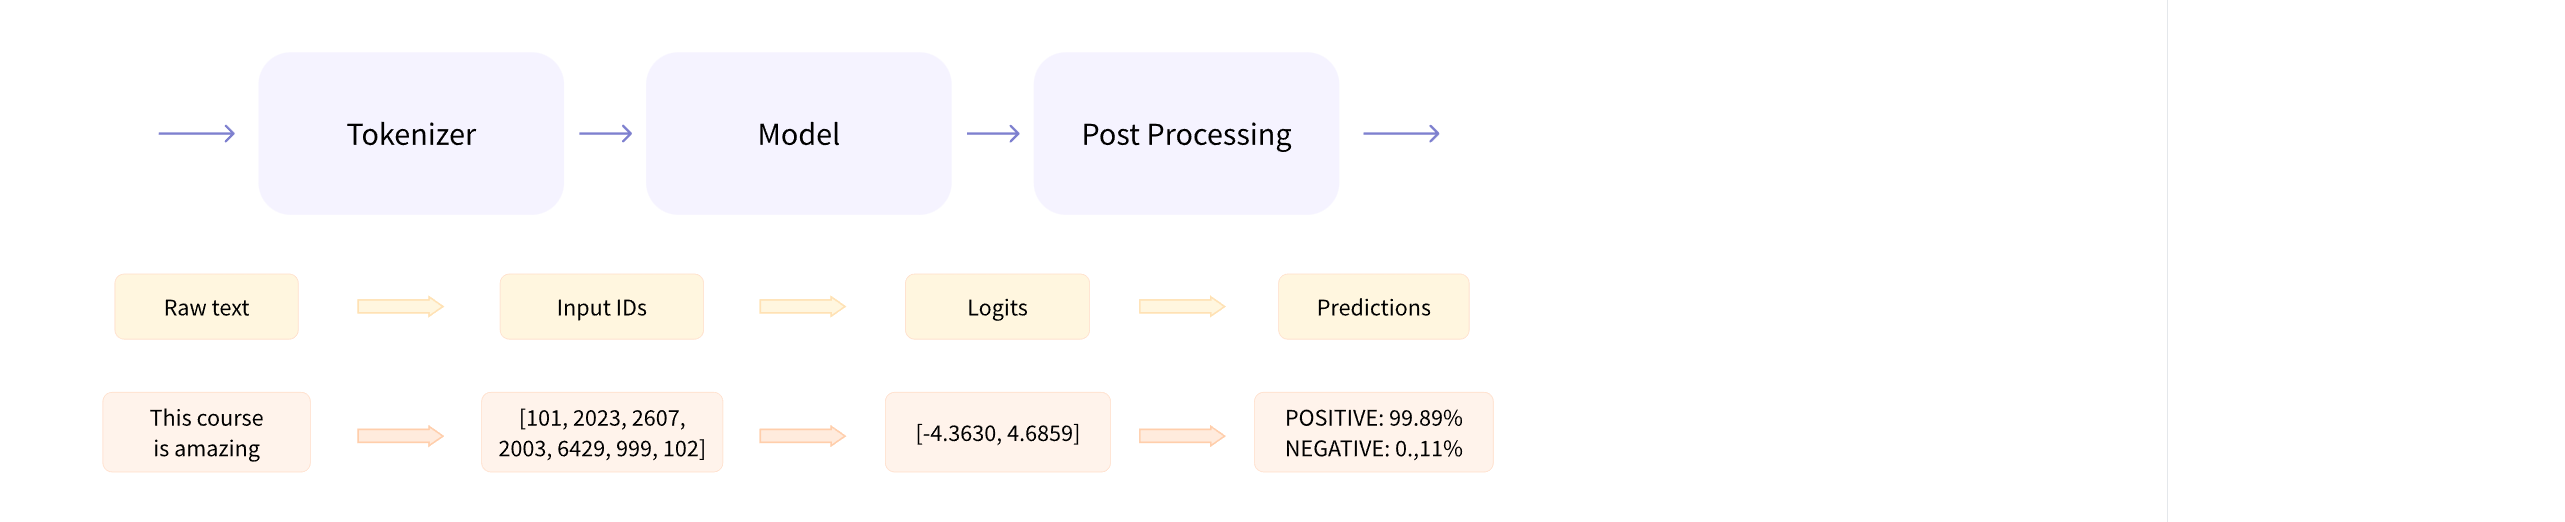

In [2]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained("siebert/sentiment-roberta-large-english")


# Initialize the model
model = AutoModelForSequenceClassification.from_pretrained("siebert/sentiment-roberta-large-english")

In [3]:
# device config (train our model on GPU if it is available which is much faster)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
print(model)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
         

In [5]:
inputs = "Uau, that is so good man!" # Man! Not idea that could be so good

In [ ]:
inputs = "Man! Not idea that could be so good!" # Man! Not idea that could be so good

In [7]:
inputs = "Oh, I am so sad, today is rainning cats!" # Man! Not idea that could be so good

In [ ]:
inputs = "This is figure 8 - chair and classification." # Man! Not idea that could be so good

In [8]:
tokenized_inputs = tokenizer(inputs, return_tensors="pt")


outputs = model(**tokenized_inputs)

labels = ['NEGATIVE', 'POSITIVE']
prediction = torch.argmax(outputs.logits)

print(f'\n1-PREDIÇÕES MAN: {(outputs.logits)}\n')


print("Input:")
print(inputs)
print()
print("Tokenized Inputs:")
print_encoding(tokenized_inputs)
print()
print("Model Outputs:")
print(outputs)
print()
print(f"The prediction is {labels[prediction]}")


1-PREDIÇÕES MAN: tensor([[ 3.4471, -2.8300]], grad_fn=<AddmmBackward0>)

Input:
Oh, I am so sad, today is rainning cats!

Tokenized Inputs:
{
    input_ids:
        tensor([[    0,  7516,     6,    38,   524,    98,  5074,     6,   452,    16,
          1895,  3509, 10017,   328,     2]])
    attention_mask:
        tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
}

Model Outputs:
SequenceClassifierOutput(loss=None, logits=tensor([[ 3.4471, -2.8300]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

The prediction is NEGATIVE


### 0.1 Tokenizers

Pretrained models are implemented along with **tokenizers** that are used to preprocess their inputs. The tokenizers take raw strings or list of strings and output what are effectively dictionaries that contain the the model inputs.


You can access tokenizers either with the Tokenizer class specific to the model you want to use (here DistilBERT), or with the AutoTokenizer class.
Fast Tokenizers are written in Rust, while their slow versions are written in Python.

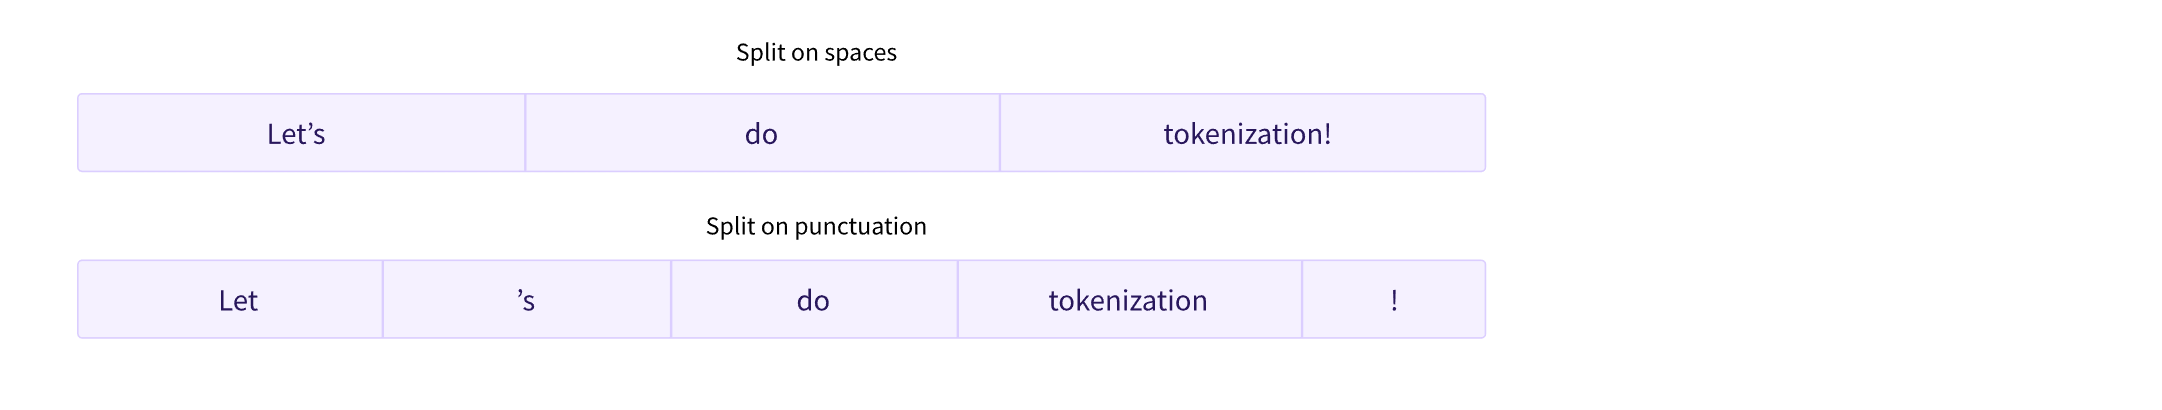

In [9]:
from transformers import DistilBertTokenizer, DistilBertTokenizerFast, AutoTokenizer

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-cased")      # written in Python
print(tokenizer)
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-cased")  # written in Rust
print(tokenizer)
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-cased") # convenient! Defaults to Fast
print(tokenizer)

DistilBertTokenizer(name_or_path='distilbert-base-cased', vocab_size=28996, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})
DistilBertTokenizerFast(name_or_path='distilbert-base-cased', vocab_size=28996, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})
DistilBertTokenizerFast(name_or_path='distilbert-base-cased', vocab_size=28996, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


In [10]:
# This is how you call the tokenizer
input_str = "Hugging Face Transformers is boring!" #Hugging Face Transformers is great!
print(f'input_str: {input_str}\n')
tokenized_inputs = tokenizer(input_str)


print("Vanilla Tokenization")
print_encoding(tokenized_inputs)
print()

# Two ways to access:
print(f'Two ways to access:\n')
print(tokenized_inputs.input_ids)
print(tokenized_inputs["input_ids"])

input_str: Hugging Face Transformers is boring!

Vanilla Tokenization
{
    input_ids:
        [101, 20164, 10932, 10289, 25267, 1110, 12533, 106, 102]
    attention_mask:
        [1, 1, 1, 1, 1, 1, 1, 1, 1]
}

Two ways to access:

[101, 20164, 10932, 10289, 25267, 1110, 12533, 106, 102]
[101, 20164, 10932, 10289, 25267, 1110, 12533, 106, 102]


In [11]:
cls = [tokenizer.cls_token_id]
sep = [tokenizer.sep_token_id]

# Tokenization happens in a few steps:
input_tokens = tokenizer.tokenize(input_str)
input_ids = tokenizer.convert_tokens_to_ids(input_tokens)
input_ids_special_tokens = cls + input_ids + sep

decoded_str = tokenizer.decode(input_ids_special_tokens)

print("start:                ", input_str)
print("tokenize:             ", input_tokens)
print("convert_tokens_to_ids:", input_ids)
print("add special tokens:   ", input_ids_special_tokens)
print("--------")
print("decode:               ", decoded_str)

# NOTE that these steps don't create the attention mask or add the special characters

start:                 Hugging Face Transformers is boring!
tokenize:              ['Hu', '##gging', 'Face', 'Transformers', 'is', 'boring', '!']
convert_tokens_to_ids: [20164, 10932, 10289, 25267, 1110, 12533, 106]
add special tokens:    [101, 20164, 10932, 10289, 25267, 1110, 12533, 106, 102]
--------
decode:                [CLS] Hugging Face Transformers is boring! [SEP]


In [12]:
# For Fast Tokenizers, there's another option too:
inputs = tokenizer._tokenizer.encode(input_str)

print(input_str)
print("-"*5)
print(f"Number of tokens: {len(inputs)}")
print(f"Ids: {inputs.ids}")
print(f"Tokens: {inputs.tokens}")
print(f"Special tokens mask: {inputs.special_tokens_mask}")
print()
print("char_to_word gives the wordpiece of a character in the input")
char_idx = 8
print(f"For example, the {char_idx + 1}th character of the string is '{input_str[char_idx]}',"+\
      f" and it's part of wordpiece {inputs.char_to_token(char_idx)}, '{inputs.tokens[inputs.char_to_token(char_idx)]}'")

Hugging Face Transformers is boring!
-----
Number of tokens: 9
Ids: [101, 20164, 10932, 10289, 25267, 1110, 12533, 106, 102]
Tokens: ['[CLS]', 'Hu', '##gging', 'Face', 'Transformers', 'is', 'boring', '!', '[SEP]']
Special tokens mask: [1, 0, 0, 0, 0, 0, 0, 0, 1]

char_to_word gives the wordpiece of a character in the input
For example, the 9th character of the string is 'F', and it's part of wordpiece 3, 'Face'


In [13]:
# Other cool tricks:
# The tokenizer can return pytorch tensors
model_inputs = tokenizer("Hugging Face Transformers is so boring!", return_tensors="pt")   # "Hugging Face Transformers is great!"
print("PyTorch Tensors:")
print_encoding(model_inputs)

PyTorch Tensors:
{
    input_ids:
        tensor([[  101, 20164, 10932, 10289, 25267,  1110,  1177, 12533,   106,   102]])
    attention_mask:
        tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
}


In [14]:
# You can pass multiple strings into the tokenizer and pad them as you need       "Hugging Face Transformers is great!"
model_inputs = tokenizer(["Hugging Face Transformers is so boring!",
                         "The quick brown fox jumps over the lazy dog." +\
                         "Then the dog got up and ran away because she didn't like foxes.",
                         ],
                         return_tensors="pt",
                         padding=True,
                         truncation=True)
print(f"Pad token: {tokenizer.pad_token} | Pad token id: {tokenizer.pad_token_id}")
print("Padding:")
print_encoding(model_inputs)

Pad token: [PAD] | Pad token id: 0
Padding:
{
    input_ids:
        tensor([[  101, 20164, 10932, 10289, 25267,  1110,  1177, 12533,   106,   102,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0],
        [  101,  1109,  3613,  3058, 17594, 15457,  1166,  1103, 16688,  3676,
           119,  1599,  1103,  3676,  1400,  1146,  1105,  1868,  1283,  1272,
          1131,  1238,   112,   189,  1176, 17594,  1279,   119,   102]])
    attention_mask:
        tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1]])
}


In [15]:
# You can also decode a whole batch at once:
print("Batch Decode:")
print(tokenizer.batch_decode(model_inputs.input_ids))
print()
print("Batch Decode: (no special characters)")
print(tokenizer.batch_decode(model_inputs.input_ids, skip_special_tokens=True))

Batch Decode:
['[CLS] Hugging Face Transformers is so boring! [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]', "[CLS] The quick brown fox jumps over the lazy dog. Then the dog got up and ran away because she didn't like foxes. [SEP]"]

Batch Decode: (no special characters)
['Hugging Face Transformers is so boring!', "The quick brown fox jumps over the lazy dog. Then the dog got up and ran away because she didn't like foxes."]


For more information about tokenizers, you can look at:
[Hugging Face Transformers Docs](https://huggingface.co/docs/transformers/main_classes/tokenizer) and the [Hugging Face Tokenizers Library](https://huggingface.co/docs/tokenizers/python/latest/quicktour.html) (For the Fast Tokenizers). The Tokenizers Library even lets you train your own tokenizers!

### 0.2 Models




Initializing models is very similar to initializing tokenizers. You can either use the model class specific to your model or you can use an AutoModel class. I tend to prefer AutoModel, especially when I want to compare models, because it's easy to specify the models as strings.

While most of the pretrained transformers have similar architecture, if you there are additional weights, called "heads" that you have to train if you're doing sequence classification, question answering, or some other task. Hugging Face automatically sets up the architecture you need when you specify the model class. For example, we are doing sentiment analysis, so we are going to use `DistilBertForSequenceClassification`. If we were going to continue training DistilBERT on its masked-language modeling training objective, we would use `DistilBertForMaskedLM`, and if we just wanted the model's representations, maybe for our own downstream task, we could just use `DistilBertModel`.


Here's a stylized picture of a model recreated from one found here: [https://huggingface.co/course/chapter2/2?fw=pt](https://huggingface.co/course/chapter2/2?fw=pt).
![model_illustration.png](attachment:model_illustration.png)


Here are some examples.
```
*
*ForMaskedLM
*ForSequenceClassification
*ForTokenClassification
*ForQuestionAnswering
*ForMultipleChoice
...
```
where `*` can be `AutoModel` or a specific pretrained model (e.g. `DistilBert`)


There are three types of models:
* Encoders (e.g. BERT)
* Decoders (e.g. GPT2)
* Encoder-Decoder models (e.g. BART or T5)

The task-specific classes you have available depend on what type of model you're dealing with.


A full list of choices are available in the [docs](https://huggingface.co/docs/transformers/model_doc/auto). Note that not all models are compatible with all model architectures, for example DistilBERT is not compatible with the Seq2Seq models because it only consists of an encoder.




======================================


A inicialização de modelos é muito semelhante à inicialização de tokenizers. Você pode usar a classe de modelo específica para seu modelo ou pode usar uma classe AutoModel. Costumo preferir AutoModel, especialmente quando quero comparar modelos, porque é fácil especificar os modelos como strings.

Embora a maioria dos transformadores pré-treinados tenha arquitetura semelhante, se houver pesos adicionais, chamados de "cabeças", que você deve treinar se estiver fazendo classificação de sequência, resposta a perguntas ou alguma outra tarefa. Hugging Face configura automaticamente a arquitetura necessária ao especificar a classe do modelo. Por exemplo, estamos fazendo análise de sentimento, então vamos usar `DistilBertForSequenceClassification`. Se íamos continuar treinando o DistilBERT em seu objetivo de treinamento de modelagem de linguagem mascarada, usaríamos `DistilBertForMaskedLM`, e se quiséssemos apenas as representações do modelo, talvez para nossa própria tarefa de downstream, poderíamos usar apenas `DistilBertModel`.


In [16]:
from transformers import AutoModelForNextSentencePrediction

In [17]:
from transformers import AutoModelForSequenceClassification, DistilBertForSequenceClassification

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-cased', num_labels=2)
model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-cased', num_labels=2)


Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier.bia

We get a warning here because the sequence classification parameters haven't been trained yet.

Passing inputs to the model is super easy. They take inputs as keyword arguments

In [18]:
model_inputs = tokenizer(input_str, return_tensors="pt")

# Option 1
model_outputs = model(input_ids=model_inputs.input_ids, attention_mask=model_inputs.attention_mask)

# Option 2 - the keys of the dictionary the tokenizer returns are the same as the keyword arguments
#            the model expects

# f({k1: v1, k2: v2}) = f(k1=v1, k2=v2)

model_outputs = model(**model_inputs)

print(model_inputs)
print()
print(model_outputs)
print()
print(f"Distribution over labels: {torch.softmax(model_outputs.logits, dim=1)}")

{'input_ids': tensor([[  101, 20164, 10932, 10289, 25267,  1110, 12533,   106,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1]])}

SequenceClassifierOutput(loss=None, logits=tensor([[0.0412, 0.0710]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

Distribution over labels: tensor([[0.4926, 0.5074]], grad_fn=<SoftmaxBackward0>)


If you notice, it's a bit weird that we have two classes for a binary classification task - you could easily have a single class and just choose a threshold. It's like this because of how huggingface models calculate the loss. This will increase the number of parameters we have, but shouldn't otherwise affect performance.

These models are just Pytorch Modules! You can can calculate the loss with your `loss_func` and call `loss.backward`. You can use any of the optimizers or learning rate schedulers that you used

In [19]:
# You can calculate the loss like normal
label = torch.tensor([1])
loss = torch.nn.functional.cross_entropy(model_outputs.logits, label)
print(loss)
loss.backward()

# You can get the parameters
list(model.named_parameters())[0]

tensor(0.6784, grad_fn=<NllLossBackward0>)


('distilbert.embeddings.word_embeddings.weight',
 Parameter containing:
 tensor([[-2.5130e-02, -3.3044e-02, -2.4396e-03,  ..., -1.0848e-02,
          -4.6824e-02, -9.4855e-03],
         [-4.8244e-03, -2.1486e-02, -8.7145e-03,  ..., -2.6029e-02,
          -3.7862e-02, -2.4103e-02],
         [-1.6531e-02, -1.7862e-02,  1.0596e-03,  ..., -1.6371e-02,
          -3.5670e-02, -3.1419e-02],
         ...,
         [-9.6466e-03,  1.4814e-02, -2.9182e-02,  ..., -3.7873e-02,
          -4.6263e-02, -1.6803e-02],
         [-1.3170e-02,  6.5378e-05, -3.7222e-02,  ..., -4.3558e-02,
          -1.1252e-02, -2.2152e-02],
         [ 1.1905e-02, -2.3293e-02, -2.2506e-02,  ..., -2.7136e-02,
          -4.3556e-02,  1.0529e-04]], requires_grad=True))

Hugging Face provides an additional easy way to calculate the loss as well:

In [20]:
# To calculate the loss, we need to pass in a label:
model_inputs = tokenizer(input_str, return_tensors="pt")

labels = ['NEGATIVE', 'POSITIVE']
model_inputs['labels'] = torch.tensor([1])

model_outputs = model(**model_inputs)


print(model_outputs)
print()
print(f"Model predictions: {labels[model_outputs.logits.argmax()]}")

SequenceClassifierOutput(loss=tensor(0.6784, grad_fn=<NllLossBackward0>), logits=tensor([[0.0412, 0.0710]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

Model predictions: POSITIVE


One final note - you can get the hidden states and attention weights from the models really easily. This is particularly helpful if you're working on an analysis project. (For example, see [What does BERT look at?](https://arxiv.org/abs/1906.04341)).

In [21]:
from transformers import AutoModel

model = AutoModel.from_pretrained("distilbert-base-cased", output_attentions=True, output_hidden_states=True)
model.eval()

model_inputs = tokenizer(input_str, return_tensors="pt")
with torch.no_grad():
    model_output = model(**model_inputs)


print("Hidden state size (per layer):  ", model_output.hidden_states[0].shape)
print("Attention head size (per layer):", model_output.attentions[0].shape)     # (layer, batch, query_word_idx, key_word_idxs)
                                                                               # y-axis is query, x-axis is key
print(model_output)    

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Hidden state size (per layer):   torch.Size([1, 9, 768])
Attention head size (per layer): torch.Size([1, 12, 9, 9])
BaseModelOutput(last_hidden_state=tensor([[[ 0.3655,  0.1416, -0.0110,  ..., -0.0110,  0.1574,  0.0773],
         [ 0.0412, -0.0702, -0.0631,  ...,  0.2090, -0.0764,  0.0231],
         [ 0.0483,  0.0985,  0.1988,  ...,  0.1545, -0.0704, -0.3218],
         ...,
         [ 0.1584,  0.1002,  0.1821,  ...,  0.2164, -0.1985,  0.3712],
         [ 0.4221,  0.2399,  0.2947,  ...,  0.3579, -0.0512,  0.3475],
         [ 0.8826,  0.5757,  0.2008,  ...,  0.3101,  0.5002,  0.0953]]]), hidden_states=(tensor([[[ 0.5521,  0.1778, -0.0585,  ..., -0.0160,  0.2085, -0.1154],
         [-0.2170, -0.9449, -1.3180,  ...,  1.2498,  0.1091, -0.4434],
         [-0.7837, -0.4800,  0.4499,  ..., -0.3740, -0.7640,  0.7910],
         ...,
         [ 0.1475, -1.3975,  0.7639,  ...,  0.6398, -0.4631,  0.6106],
         [-0.5610,  0.9675,  0.8943,  ...,  0.7401, -1.1003,  0.0229],
         [-0.4382,  0.0

['[CLS]', 'Hu', '##gging', 'Face', 'Transformers', 'is', 'boring', '!', '[SEP]']


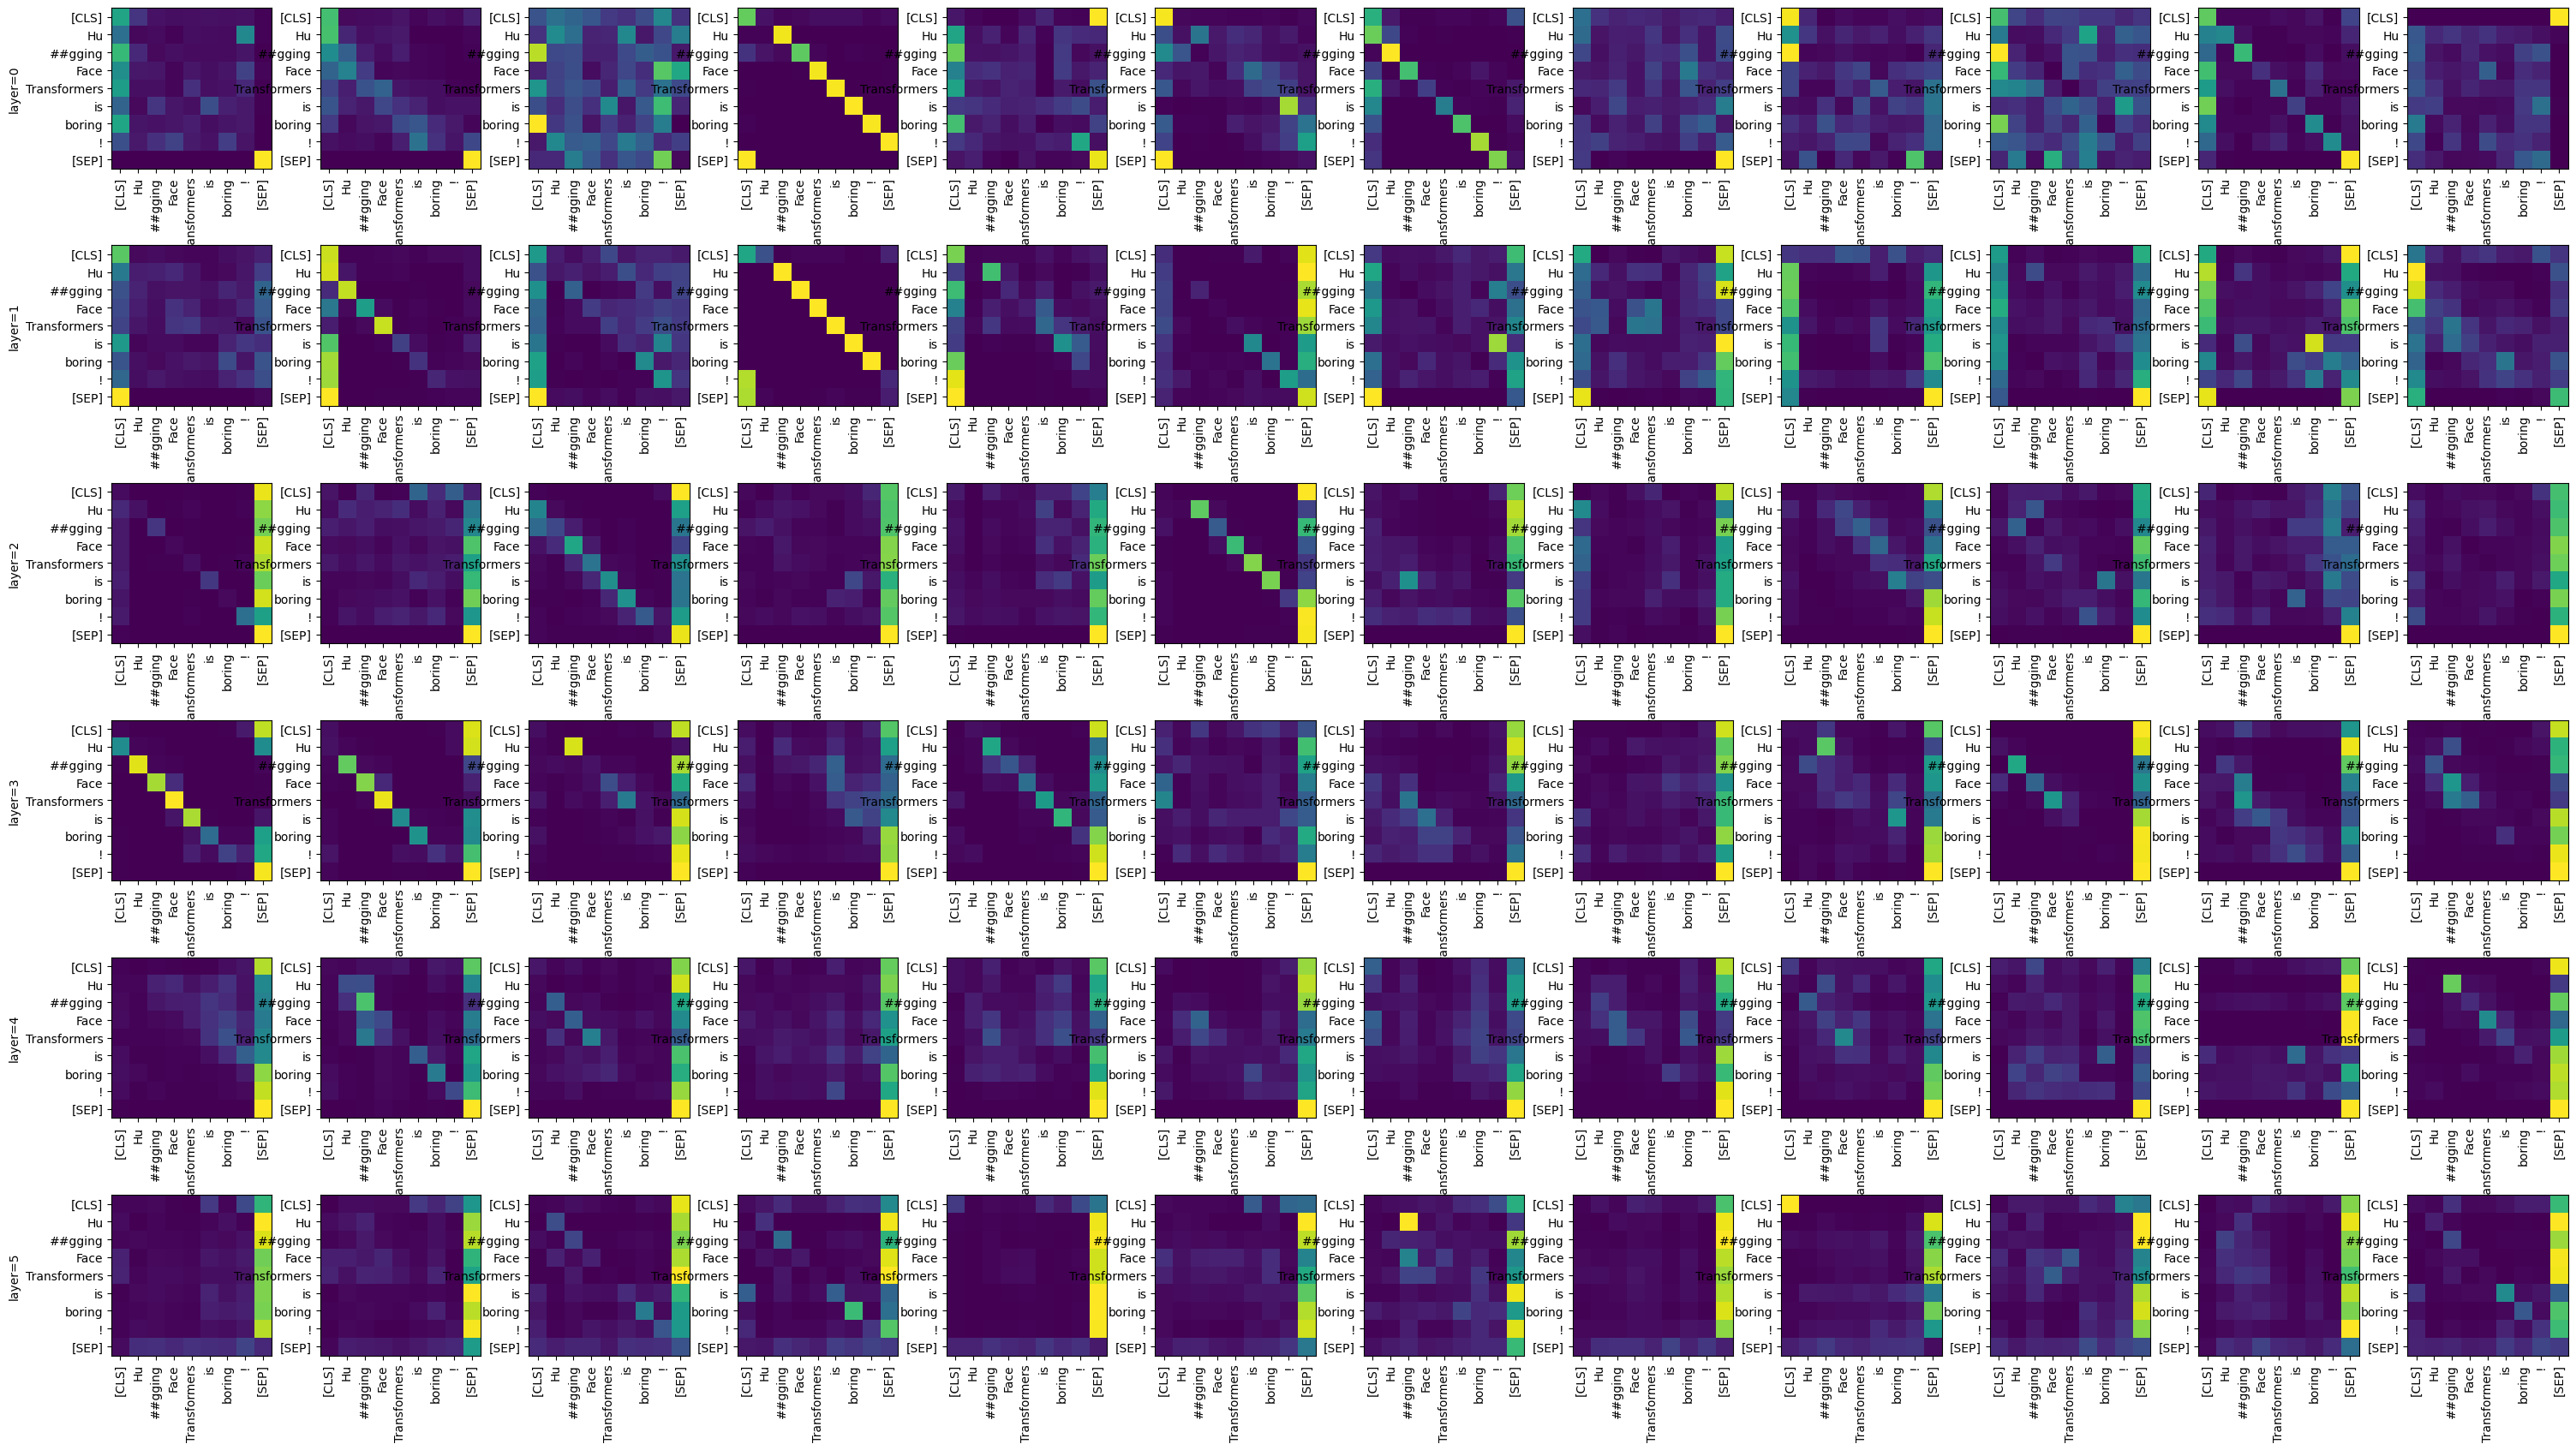

In [22]:
tokens = tokenizer.convert_ids_to_tokens(model_inputs.input_ids[0])
print(tokens)


n_layers = len(model_output.attentions)
n_heads = len(model_output.attentions[0][0])
fig, axes = plt.subplots(6, 12)
fig.set_size_inches(18.5*2, 10.5*2)
for layer in range(n_layers):
    for i in range(n_heads):
        axes[layer, i].imshow(model_output.attentions[layer][0, i])
        axes[layer][i].set_xticks(list(range(9)))
        axes[layer][i].set_xticklabels(labels=tokens, rotation="vertical")
        axes[layer][i].set_yticks(list(range(9)))
        axes[layer][i].set_yticklabels(labels=tokens)

        if layer == 3:
            axes[layer, i].set(xlabel=f"head={i}")
        if i == 0:
            axes[layer, i].set(ylabel=f"layer={layer}")
            
plt.subplots_adjust(wspace=0.3)
plt.show()

## Part 1: Finetuning

For your projects, you are much more likely to want to finetune a pretrained model. This is a little bit more involved, but is still quite easy.

### 2.1 Loading in a dataset

In addition to having models, the [the hub](https://huggingface.co/datasets) also has datasets.

In [23]:
from datasets import load_dataset, DatasetDict


# DataLoader(zip(list1, list2))


imdb_dataset = load_dataset("imdb")


# Just take the first 50 tokens for speed/running on cpu
def truncate(example):
    return {
        'text': " ".join(example['text'].split()[:50]),
        'label': example['label']
    }

# Take 128 random examples for train and 32 validation
small_imdb_dataset = DatasetDict(
    train=imdb_dataset['train'].shuffle(seed=1111).select(range(128)).map(truncate),
    val=imdb_dataset['train'].shuffle(seed=1111).select(range(128, 160)).map(truncate),
)

Found cached dataset imdb (/home/dani-boy/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached shuffled indices for dataset at /home/dani-boy/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-44ad9ef44a26214e.arrow
Loading cached processed dataset at /home/dani-boy/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-7b6643e860da141c.arrow
Loading cached shuffled indices for dataset at /home/dani-boy/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-44ad9ef44a26214e.arrow
Loading cached processed dataset at /home/dani-boy/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-d3d289c2e4f2e104.arrow


In [24]:


small_imdb_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 128
    })
    val: Dataset({
        features: ['text', 'label'],
        num_rows: 32
    })
})

In [25]:
small_imdb_dataset['train'][:10]

{'text': ["Probably Jackie Chan's best film in the 1980s, and the one that put him on the map. The scale of this self-directed police drama is evident from the opening and closing scenes, during which a squatters' village and shopping mall are demolished. There are, clearly, differences between the original Chinese",
  'A wonderful movie! Anyone growing up in an Italian family will definitely see themselves in these characters. A good family movie with sadness, humor, and very good acting from all. You will enjoy this movie!! We need more like it.',
  'HORRENDOUS! Avoid like the plague. I would rate this in the top 10 worst movies ever. Special effects, acting, mood, sound, etc. appear to be done by day care students...wait, I have seen programs better than this. Opens like a soft porn show with a blurred nude female doing a',
  'And I absolutely adore Isabelle Blais!!! She was so cute in this movie, and far different from her role in "Quebec-Montreal" where she was more like a man-eat

In [26]:
# Prepare the dataset - this tokenizes the dataset in batches of 16 examples.
small_tokenized_dataset = small_imdb_dataset.map(
    lambda example: tokenizer(example['text'], padding=True, truncation=True),
    batched=True,
    batch_size=16
)

small_tokenized_dataset = small_tokenized_dataset.remove_columns(["text"])
small_tokenized_dataset = small_tokenized_dataset.rename_column("label", "labels")
small_tokenized_dataset.set_format("torch")

Loading cached processed dataset at /home/dani-boy/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-6068d29bf0235666.arrow
Loading cached processed dataset at /home/dani-boy/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-e486f533f0b5c5f7.arrow


In [27]:
small_tokenized_dataset['train'][0:2]

{'labels': tensor([1, 1]),
 'input_ids': tensor([[  101, 10109,  9662, 10185,   112,   188,  1436,  1273,  1107,  1103,
           3011,   117,  1105,  1103,  1141,  1115,  1508,  1140,  1113,  1103,
           4520,   119,  1109,  3418,  1104,  1142,  2191,   118,  2002,  2021,
           3362,  1110, 10238,  1121,  1103,  2280,  1105,  5134,  4429,   117,
           1219,  1134,   170,  4816,  6718, 18899,   112,  1491,  1105,  6001,
           8796,  1132,  6515,   119,  1247,  1132,   117,  3817,   117,  5408,
           1206,  1103,  1560,  1922,   102,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0],
         [  101,   138,  7310,  2523,   106, 15859,  2898,  1146,  1107,  1126,
           2169,  1266,  1209,  5397,  1267,  2310,  1107,  1292,  2650,   119,
            138,  1363,  1266,  2523,  1114, 12928,   1

In [28]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(small_tokenized_dataset['train'], batch_size=16)
eval_dataloader = DataLoader(small_tokenized_dataset['val'], batch_size=16)

### 2.2 Training

To train your models, you can just use the same kind of training loop that you would use in Pytorch. Hugging Face models are also `torch.nn.Module`s so backpropagation happens the same way and you can even use the same optimizers. Hugging Face also includes optimizers and learning rate schedules that were used to train Transformer models, so you can use these too.

For optimization, we're using the AdamW Optimizer, which is almost identical to Adam except it also includes weight decay.
And we're using a linear learning rate scheduler, which reduces the learning rate a little bit after each training step over the course of training.

There are other optimizers and learning rate schedulers you can use, but these are the default. If you want to explore, you can look at the ones [Hugging Face offers](https://huggingface.co/docs/transformers/main_classes/optimizer_schedules#schedules), the ones available through [Pytorch](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate) (e.g. [ReduceLROnPlateau](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html), which only decreases the learning rate when the validation loss stops decreasing), or write your own (like the one in Assignment 4).

In [29]:
from transformers import AdamW, get_linear_schedule_with_warmup
from tqdm.notebook import tqdm


model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-cased', num_labels=2)

num_epochs = 3
num_training_steps = 3 * len(train_dataloader)
optimizer = AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)
lr_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

best_val_loss = float("inf")
progress_bar = tqdm(range(num_training_steps))
for epoch in range(num_epochs):
    # training
    model.train()
    for batch_i, batch in enumerate(train_dataloader):
        
        # batch = ([text1, text2], [0, 1])

        output = model(**batch)
        
        optimizer.zero_grad()
        output.loss.backward()
        optimizer.step()
        lr_scheduler.step()
        progress_bar.update(1)
    
    # validation
    model.eval()
    for batch_i, batch in enumerate(eval_dataloader):
        with torch.no_grad():
            output = model(**batch)
        loss += output.loss
    
    avg_val_loss = loss / len(eval_dataloader)
    print(f"Validation loss: {avg_val_loss}")
    if avg_val_loss < best_val_loss:
        print("Saving checkpoint!")
        best_val_loss = avg_val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': best_val_loss,
            },
            f"checkpoints/epoch_{epoch}.pt"
        )  

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier.bia

  0%|          | 0/24 [00:00<?, ?it/s]

Validation loss: 1.0137674808502197
Saving checkpoint!
Validation loss: 1.6606450080871582
Validation loss: 2.279204845428467


While you can use PyTorch to train your models like we did in Assignment 4, Hugging Face offers a powerful `Trainer` class to handle most needs. I think it works pretty well, though there are some customizations I'd recommend.

In [30]:
imdb_dataset = load_dataset("imdb")

small_imdb_dataset = DatasetDict(
    train=imdb_dataset['train'].shuffle(seed=1111).select(range(128)).map(truncate),
    val=imdb_dataset['train'].shuffle(seed=1111).select(range(128, 160)).map(truncate),
)

small_tokenized_dataset = small_imdb_dataset.map(
    lambda example: tokenizer(example['text'], truncation=True),
    batched=True,
    batch_size=16
)

Found cached dataset imdb (/home/dani-boy/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached shuffled indices for dataset at /home/dani-boy/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-44ad9ef44a26214e.arrow
Loading cached processed dataset at /home/dani-boy/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-7b6643e860da141c.arrow
Loading cached shuffled indices for dataset at /home/dani-boy/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-44ad9ef44a26214e.arrow
Loading cached processed dataset at /home/dani-boy/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-d3d289c2e4f2e104.arrow
Loading cached processed dataset at /home/dani-boy/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-2174933a832b1d26.arrow


  0%|          | 0/2 [00:00<?, ?ba/s]

`TrainingArguments` specifies different training parameters like how often to evaluate and save model checkpoints, where to save them, etc. There are **many** aspects you can customize and it's worth checking them out [here](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments). Some things you can control include:
* learning rate, weight decay, gradient clipping, 
* checkpointing, logging, and evaluation frequency
* where you log to (default is tensorboard, but if you use WandB or MLFlow they have integrations)

The `Trainer` actually performs the training. You can pass it the `TrainingArguments`, model, the datasets, tokenizer, optimizer, and even model checkpoints to resume training from. The `compute_metrics` function is called at the end of evaluation/validation to calculate evaluation metrics.

In [31]:
from transformers import TrainingArguments, Trainer

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-cased', num_labels=2)

arguments = TrainingArguments(
    output_dir="sample_hf_trainer",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    evaluation_strategy="epoch", # run validation at the end of each epoch
    save_strategy="epoch",
    learning_rate=2e-5,
    load_best_model_at_end=True,
    seed=224
)


def compute_metrics(eval_pred):
    """Called at the end of validation. Gives accuracy"""
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    # calculates the accuracy
    return {"accuracy": np.mean(predictions == labels)}


trainer = Trainer(
    model=model,
    args=arguments,
    train_dataset=small_tokenized_dataset['train'],
    eval_dataset=small_tokenized_dataset['val'], # change to test when you do your final evaluation!
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier.bia

#### Callbacks: Logging and Early Stopping


Hugging Face Transformers also allows you to write `Callbacks` if you want certain things to happen at different points during training (e.g. after evaluation or after an epoch has finished). For example, there is a callback for early stopping, and I usually write one for logging as well.

For more information on callbacks see [here](https://huggingface.co/docs/transformers/main_classes/callback#transformers.TrainerCallback).

In [32]:
from transformers import TrainerCallback, EarlyStoppingCallback

class LoggingCallback(TrainerCallback):
    def __init__(self, log_path):
        self.log_path = log_path
        
    def on_log(self, args, state, control, logs=None, **kwargs):
        _ = logs.pop("total_flos", None)
        if state.is_local_process_zero:
            with open(self.log_path, "a") as f:
                f.write(json.dumps(logs) + "\n")


trainer.add_callback(EarlyStoppingCallback(early_stopping_patience=1, early_stopping_threshold=0.0))
trainer.add_callback(LoggingCallback("sample_hf_trainer/log.jsonl"))

In [33]:
# train the model
trainer.train()

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
/home/dani-boy/miniconda3/envs/transformers/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 128
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 24
  Number of trainable parameters = 65783042
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.675331,0.687500
2,No log,0.670376,0.687500
3,No log,0.666052,0.687500


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 32
  Batch size = 16
Saving model checkpoint to sample_hf_trainer/checkpoint-8
Configuration saved in sample_hf_trainer/checkpoint-8/config.json
Model weights saved in sample_hf_trainer/checkpoint-8/pytorch_model.bin
tokenizer config file saved in sample_hf_trainer/checkpoint-8/tokenizer_config.json
Special tokens file saved in sample_hf_trainer/checkpoint-8/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation **

TrainOutput(global_step=24, training_loss=0.6746997038523356, metrics={'train_runtime': 17.0485, 'train_samples_per_second': 22.524, 'train_steps_per_second': 1.408, 'train_loss': 0.6746997038523356, 'epoch': 3.0})

In [34]:
# evaluating the model is very easy

# results = trainer.evaluate()                           # just gets evaluation metrics
results = trainer.predict(small_tokenized_dataset['val']) # also gives you predictions

The following columns in the test set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 32
  Batch size = 16


In [35]:
results

PredictionOutput(predictions=array([[-0.07417656, -0.09589677],
       [-0.06221755, -0.11323086],
       [-0.03299606, -0.0519148 ],
       [-0.03110218, -0.07258837],
       [-0.16203912,  0.01937629],
       [-0.03009157, -0.10766719],
       [ 0.01191566, -0.15896028],
       [-0.05413074, -0.06087763],
       [-0.15715784, -0.04094571],
       [-0.09851558, -0.05232234],
       [-0.08766381, -0.04370203],
       [ 0.05695225, -0.1448596 ],
       [ 0.07237729, -0.1485669 ],
       [-0.05878286, -0.07086833],
       [-0.00142749, -0.11308745],
       [ 0.07558997, -0.14288712],
       [-0.01357452, -0.17301162],
       [-0.1293478 , -0.02237627],
       [-0.04092607, -0.10576309],
       [-0.18657014, -0.01632939],
       [ 0.02892027, -0.11002116],
       [-0.00901863, -0.09123674],
       [-0.06989376, -0.05847109],
       [-0.05572559, -0.09802491],
       [-0.02593987, -0.10443713],
       [-0.07562542, -0.07626103],
       [-0.13208017, -0.02111974],
       [-0.07769332, -0.09

In [36]:
# To load our saved model, we can pass the path to the checkpoint into the `from_pretrained` method:
test_str = "Prince of Tides is a wonderful movie if you want to have a bad day because the movie makes you really sad."

finetuned_model = AutoModelForSequenceClassification.from_pretrained("sample_hf_trainer/checkpoint-24")
model_inputs = tokenizer(test_str, return_tensors="pt")
prediction = torch.argmax(finetuned_model(**model_inputs).logits)
print(["NEGATIVE", "POSITIVE"][prediction])

loading configuration file sample_hf_trainer/checkpoint-24/config.json
Model config DistilBertConfig {
  "_name_or_path": "sample_hf_trainer/checkpoint-24",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.26.1",
  "vocab_size": 28996
}

loading weights file sample_hf_trainer/checkpoint-24/pytorch_model.bin
All model checkpoint weights were used when initializing DistilBertForSequenceClassification.

All the weights of DistilBertForSequenceClassification were initialized from the model

POSITIVE


Included here are also some practical tips for fine-tuning:

**Good default hyperparameters.** The hyperparameters you will depend on your task and dataset. You should do a hyperparameter search to find the best ones. That said, here are some good initial values for fine-tuning.
* Epochs: {2, 3, 4} (larger amounts of data need fewer epochs)
* Batch size (bigger is better: as large as you can make it)
* Optimizer: AdamW
* AdamW learning rate: {2e-5, 5e-5}
* Learning rate scheduler: linear warm up for first {0, 100, 500} steps of training
* weight_decay (l2 regularization): {0, 0.01, 0.1}

You should monitor your validation loss to decide when you've found good hyperparameters.

There's a lot more that we can integrate into the Trainer to make it more useful including logging, saving model checkpoints, and more! You can even sub-class it to add your own personalized components. You can check out [this link](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.Trainer) for more information about the Trainer.

## Appendix 0: Generation

In the example above we finetuned the model on a classification task, but you can also finetune models on generation tasks. The `generate` function makes it easy to generate from these models. For example.

In [37]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained("siebert/sentiment-roberta-large-english")


# Initialize the model
model = AutoModelForSequenceClassification.from_pretrained("siebert/sentiment-roberta-large-english")

loading configuration file config.json from cache at /home/dani-boy/.cache/huggingface/hub/models--siebert--sentiment-roberta-large-english/snapshots/e78aa2b262b5f58e659fd765676b19c16a34f745/config.json
Model config RobertaConfig {
  "_name_or_path": "siebert/sentiment-roberta-large-english",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "id2label": {
    "0": "NEGATIVE",
    "1": "POSITIVE"
  },
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "label2id": {
    "NEGATIVE": 0,
    "POSITIVE": 1
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.26.1"

In [38]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [39]:
from transformers import AutoModelForCausalLM

gpt2_tokenizer = AutoTokenizer.from_pretrained('gpt2')

gpt2 = AutoModelForCausalLM.from_pretrained('distilgpt2')
gpt2.config.pad_token_id = gpt2.config.eos_token_id  # Prevents warning during decoding

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file config.json from cache at /home/dani-boy/.cache/huggingface/hub/models--gpt2/snapshots/e7da7f221d5bf496a48136c0cd264e630fe9fcc8/config.json
Model config GPT2Config {
  "_name_or_path": "gpt2",
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
  

In [40]:
prompt = "GPT-2 seems fine but, in reality..."

tokenized_prompt = gpt2_tokenizer(prompt, return_tensors="pt")

for i in range(10):
    output = gpt2.generate(**tokenized_prompt,
                  max_length=50,
                  do_sample=True,
                  top_p=0.9)

    print(f"{i + 1}) {gpt2_tokenizer.batch_decode(output)[0]}")

Generate config GenerationConfig {
  "bos_token_id": 50256,
  "eos_token_id": 50256,
  "pad_token_id": 50256,
  "transformers_version": "4.26.1"
}

/home/dani-boy/miniconda3/envs/transformers/lib/python3.9/site-packages/transformers/generation/utils.py:1186: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(
Generate config GenerationConfig {
  "bos_token_id": 50256,
  "eos_token_id": 50256,
  "pad_token_id": 50256,
  "transformers_version": "4.26.1"
}



1) GPT-2 seems fine but, in reality... the idea that you should be a professional athlete doesn't seem as easy as you might think. The truth is that there's no such thing as a true professional athlete. You're just a professional


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "eos_token_id": 50256,
  "pad_token_id": 50256,
  "transformers_version": "4.26.1"
}



2) GPT-2 seems fine but, in reality... I am a young man. My mother went to school, and she was just fine. Now, with all these other things in mind, my dad is a good guy, and it's the


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "eos_token_id": 50256,
  "pad_token_id": 50256,
  "transformers_version": "4.26.1"
}



3) GPT-2 seems fine but, in reality... it's not much, but it might be fine too.
It turns out that the next generation of mobile phones will include the newest version of their 'Aware', which will take a look


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "eos_token_id": 50256,
  "pad_token_id": 50256,
  "transformers_version": "4.26.1"
}



4) GPT-2 seems fine but, in reality...there is a real risk of it being a result of some unknown nature.<|endoftext|>


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "eos_token_id": 50256,
  "pad_token_id": 50256,
  "transformers_version": "4.26.1"
}



5) GPT-2 seems fine but, in reality... it‭
The new film ‏Alfred‏ has come a long way, and the movie ‏Alfred‏ has been the biggest disappointment. “This


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "eos_token_id": 50256,
  "pad_token_id": 50256,
  "transformers_version": "4.26.1"
}



6) GPT-2 seems fine but, in reality...I would love to get more to know me.

This is a story on the subject of a new study on brain-reinforcement learning (CBT). The research was done on


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "eos_token_id": 50256,
  "pad_token_id": 50256,
  "transformers_version": "4.26.1"
}



7) GPT-2 seems fine but, in reality... they were pretty solid, the next step is to go back and build the deck. If they can get their cards in the right format with the right mana and a decent amount of mana, then


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "eos_token_id": 50256,
  "pad_token_id": 50256,
  "transformers_version": "4.26.1"
}



8) GPT-2 seems fine but, in reality... I'd rather give this guy a free one to try out, even if the price will go up after the rest.<|endoftext|>


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "eos_token_id": 50256,
  "pad_token_id": 50256,
  "transformers_version": "4.26.1"
}



9) GPT-2 seems fine but, in reality... this is not as good as I'd like, as a real thing!<|endoftext|>
10) GPT-2 seems fine but, in reality...the next step is the right thing to do....I know there's a lot of great information out there regarding the new rules. It's nice to see people start taking care of that."<|endoftext|>


## Appendix 1: Defining Custom Datasets

There are a few ways to go about defining datasets, but I'm going to show an example using Pytorch Dataloaders. This example uses an encoder-decoder dataaset,the [E2E Dataset](https://arxiv.org/abs/1706.09254), which is maps structured information about restaurants to natural language descriptions.

In [41]:
# Option 1: Load into Hugging Face Datasets

import pandas as pd
from datasets import Dataset

df = pd.read_csv("e2e-dataset/trainset.csv")
custom_dataset = Dataset.from_pandas(df)

In [42]:
import csv
from torch.utils.data import Dataset, DataLoader

class E2EDataset(Dataset):
    """Tokenize data when we call __getitem__"""
    def __init__(self, path, tokenizer):
        with open(path, newline="") as f:
            reader = csv.reader(f)
            next(reader) # skip the heading
            self.data = [{"source": row[0], "target": row[1]} for row in reader]
        self.tokenizer = tokenizer
            
    def __getitem__(self, i):
        inputs = self.tokenizer(self.data[i]['source'])
        labels = self.tokenizer(self.data[i]['target'])
        inputs['labels'] = labels.input_ids
        return inputs


In [43]:
bart_tokenizer = AutoTokenizer.from_pretrained('facebook/bart-base')

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file config.json from cache at /home/dani-boy/.cache/huggingface/hub/models--facebook--bart-base/snapshots/aadd2ab0ae0c8268c7c9693540e9904811f36177/config.json
Model config BartConfig {
  "_name_or_path": "facebook/bart-base",
  "activation_dropout": 0.1,
  "activation_function": "gelu",
  "add_bias_logits": false,
  "add_final_layer_norm": false,
  "architectures": [
    "BartModel"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 0,
  "classif_dropout": 0.1,
  "classifier_dropout": 0.0,
  "d_model": 768,
  "decoder_attention_heads": 12,
  "decoder_ffn_dim": 3072,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "decoder_start_token_id": 2,
  "dropout": 0.1,
  "early_stopping": true,
  "encoder_attention_heads": 12,
  "encoder_ffn_dim": 3072,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 6,
  "eos_token_id": 2,
  "forced_bos_token_id": 0,
  "forced_eos_token_id": 

In [44]:
dataset = E2EDataset("e2e-dataset/trainset.csv", bart_tokenizer)

In [45]:
bart_tokenizer.prepare_seq2seq_batch(src_texts=["This is the first test.", "This is the second test."], tgt_texts=["Target 1", "Target 2"], return_tensors="pt")

/home/dani-boy/miniconda3/envs/transformers/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:3707: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and targets.

Here is a short example:

model_inputs = tokenizer(src_texts, text_target=tgt_texts, ...)

If you either need to use different keyword arguments for the source and target texts, you should do two calls like
this:

model_inputs = tokenizer(src_texts, ...)
labels = tokenizer(text_target=tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `prepare_seq2seq_batch`.

  warnings.warn(formatted_warning, FutureWarning)
/home/dani-boy/miniconda3/envs/transformers/lib/python3.9/site-packages/transformers/tokenizatio

{'input_ids': tensor([[   0,  713,   16,    5,   78, 1296,    4,    2],
        [   0,  713,   16,    5,  200, 1296,    4,    2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1]]), 'labels': tensor([[    0, 41858,   112,     2],
        [    0, 41858,   132,     2]])}

In [46]:
dataset[0]

{'input_ids': [0, 13650, 10975, 133, 48596, 7479, 3529, 40118, 10975, 22478, 7479, 425, 43430, 10975, 4321, 87, 984, 541, 7479, 2111, 691, 10975, 245, 66, 9, 195, 7479, 583, 10975, 347, 2001, 1140, 1614, 1069, 5183, 742, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'labels': [0, 133, 48596, 8881, 583, 22450, 1614, 1069, 5183, 34, 10, 195, 999, 691, 4, 1437, 14614, 386, 23, 984, 541, 4, 2]}

## Appendix 2: Pipelines

There are some standard NLP tasks like sentiment classification or question answering where there are already pre-trained (and fine-tuned!) models available through Hugging Face Transformer's [_Pipeline_](https://huggingface.co/docs/transformers/v4.16.2/en/main_classes/pipelines#transformers.pipeline) interface. 

For your projects, you likely won't be using it too much, but it's still worth knowing about!

Here's an example with Sentiment Analysis:

In [47]:
from transformers import pipeline

sentiment_analysis = pipeline("sentiment-analysis", model="siebert/sentiment-roberta-large-english")

loading configuration file config.json from cache at /home/dani-boy/.cache/huggingface/hub/models--siebert--sentiment-roberta-large-english/snapshots/e78aa2b262b5f58e659fd765676b19c16a34f745/config.json
Model config RobertaConfig {
  "_name_or_path": "siebert/sentiment-roberta-large-english",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "id2label": {
    "0": "NEGATIVE",
    "1": "POSITIVE"
  },
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "label2id": {
    "NEGATIVE": 0,
    "POSITIVE": 1
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.26.1"

: 

: 

You can run the pipeline by just calling it on a string

In [ ]:
sentiment_analysis("You would be hard press to find a more emotionally wrenching episode in television than this one." +\
                    "Ever since the beginning of the series it has been clear that in this world you need to make sacrifices to survive," +\
                    "but sacrifices are not very easy to make, and they can have irreparable consequences. Melanie Lynskey's Kathleen" +\
                    "that we met in the last episode is thirsty for revenge, her brother was executed by FEDRA because he was betrayed by " +\
                    "a man named Henry, and now she wants vengeance. But when vengeance consumes someone they might be willing to do unspeakable" +\
                    "things to quench that thirst. The writers of this episode understood the task of letting the audience understand where she" +\
                    "comes from, and what were the circumstances that led Henry to betray Kathleen's brother, but" +\
                    "they were unafraid and unapologetic when it came time to the reckoning. This is the kind of "+\
                    "gut-wrenching episode that will stay with you for a long time after the credits roll. It will also" +\
                    "give a new meaning to the series' motto 'Save who you can save'.")


In [ ]:
sentiment_analysis("Shotgun Wedding is a bad action romantic comedy film that has a dull plot, lacks the fun humor," +\
                    "and the script offers nothing surprising for its genre. Josh Duhamel and Jennifer Lopez are both great" +\
                    "and fun likable actors. Sadly, the script offers nothing new or fun for there characters. The humor is" +\
                    "very few in between scenes. Most of the humor it aims for is unfunny. The action is nothing new to the film." +\
                    "The plot is boring. About a couple about to get married on an island only to be crashed by pirates. And occasionally" +\
                    "a predictable plot twist that is easily foreshadowed in the beginning. Overall, it is one dull action comedy film that is left alone on that island")

Or on a list of strings:

In [ ]:
sentiment_analysis(["I didn't know if I would like Hákarl, but it turned out pretty good.",
                    "I didn't know if I would like Hákarl, and it was just as bad as I'd heard."])

You can find more information on pipelines (including which ones are available) [here](https://huggingface.co/docs/transformers/main_classes/pipelines)

## Appendix 4: Masked Language Modeling

In [ ]:
from transformers import AutoModelForMaskedLM

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased", fast=True)
bert = AutoModelForMaskedLM.from_pretrained("bert-base-cased")

In [ ]:
prompt = "I am [MASK] to learn about HuggingFace!"
model = pipeline("fill-mask", "bert-base-cased")
model(prompt)

In [ ]:
inputs = tokenizer(prompt, return_tensors="pt")
mask_index = np.where(inputs['input_ids'] == tokenizer.mask_token_id)
outputs = bert(**inputs)
top_5_predictions = torch.softmax(outputs.logits[mask_index], dim=1).topk(5)

print(prompt)
for i in range(5):
    prediction = tokenizer.decode(top_5_predictions.indices[0, i])
    prob = top_5_predictions.values[0, i]
    print(f"  {i+1}) {prediction}\t{prob:.3f}")